In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import sys
sys.path.append("..")
sys.path.append("../src")
sys.path.append("../utils")
sys.path.append("../phantoms")
sys.path.append("../projections")
from src.algorithms_OhGreat.DART import *
from src.algorithms_OhGreat.SART import *
from src.algorithms_OhGreat.SIRT import *
from src.algorithms_OhGreat.FBP import *
from src.projections_OhGreat.project import *
from src.phantoms_OhGreat.creator import *


<h4>Semilunar phantom creation</h4>

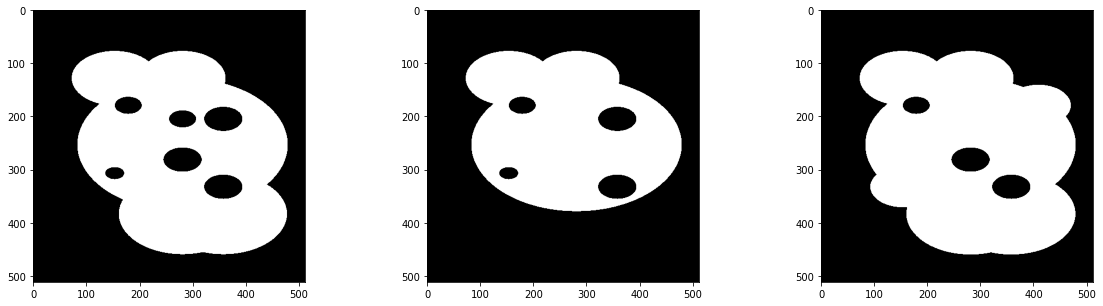

In [2]:
phantoms = create_phantoms("clouds", 512, n=3, overlap=True,
                                seed=0, img_name=None)
fig, ax = plt.subplots(1, len(phantoms), figsize=(20,5))
for i in range(len(phantoms)):
    ax[i].imshow(phantoms[i], cmap="Greys_r")

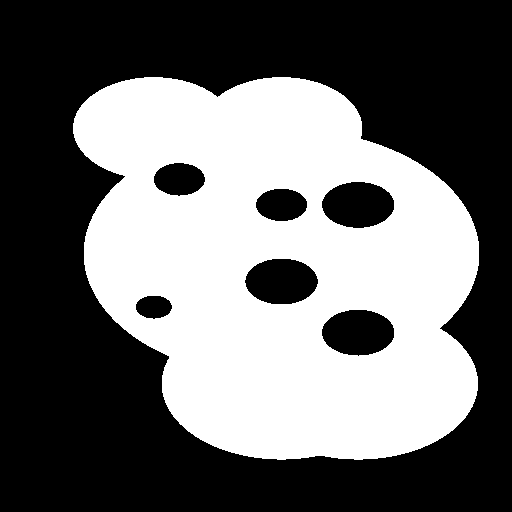

In [3]:
Image.fromarray(phantoms[0])

<h4>Measurement parameters for DART</h4>

In [3]:
# measurement parameters
n_projections = 8
n_detectors = 512
det_spacing = 1
noise_factor = None
angles = np.linspace(0, np.pi*(120/180), n_projections)
# dart paramenters
dart_iters = 10
p = 0.99
rec_alg = 'SART_CUDA'
rec_iters = 1000
# compared algs iters
comp_iters = dart_iters * rec_iters

# open phantom
img = phantoms[0]
img_width, img_height = img.shape
gray_lvls = np.unique(img).astype(np.float16)
img_width, img_height = img.shape

# prepare all the data
img_width, img_height = img.shape
gray_lvls = np.unique(img).astype(np.float16)
vol_geom = astra.creators.create_vol_geom([img_width,img_height])
phantom_id = astra.data2d.create('-vol', vol_geom, data=img)

# make measurements
projector_id, sino_id, sinogram = project_from_2D(phantom_id=phantom_id,
                                                vol_geom=vol_geom,
                                                n_projections=n_projections,
                                                n_detectors=n_detectors,
                                                detector_spacing=det_spacing,
                                                angles=angles,
                                                noise_factor=noise_factor,
                                                use_gpu=True)

proj_geom = astra.create_proj_geom('parallel', det_spacing, 
                                        n_detectors, angles)

# instanciate DART
dart = DART(gray_levels=gray_lvls, p=p, rec_shape=img.shape,
        proj_geom=proj_geom, projector_id=projector_id,
        sinogram=sinogram)

<h4>Initial reconstruction</h4>

Mean absolute pixel error: 10.38173011049787


(-0.5, 511.5, 511.5, -0.5)

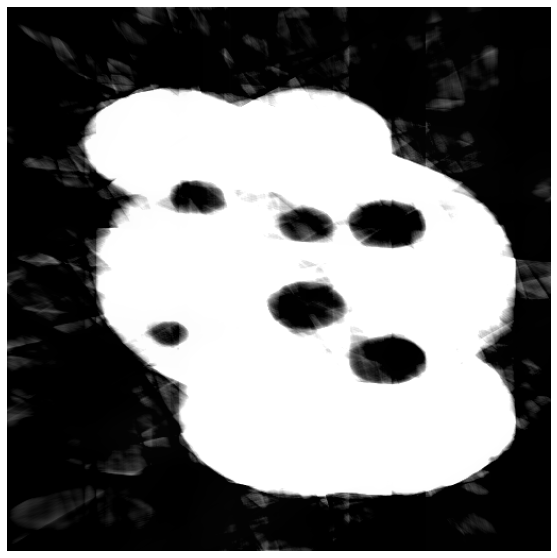

In [6]:
# fix gray levels and thresholds
dart.gray_levels = np.unique(img).astype(np.float16)
dart.gray_levels -= 5 # Add offset of 5, so min gray level is negative
dart.thresholds = dart.update_gray_thresholds()
# run the algorithm for 0 iterations
init_rec = dart.run(iters=0, rec_alg=rec_alg, rec_iter=rec_iters)
print(f"Mean absolute pixel error: {np.abs(img - init_rec).mean()}")
plt.figure(figsize=(10,10)); plt.imshow(init_rec,cmap='gray'); plt.axis('off')

<br/>
<h4>Segmentation step</h4>

Initial gray levels: [0, 122.5, 255]
Gray levels in segmented image: [ -5   0 250]
Mean absolute pixel error: 4.687175750732422
Segmented image:


(-0.5, 511.5, 511.5, -0.5)

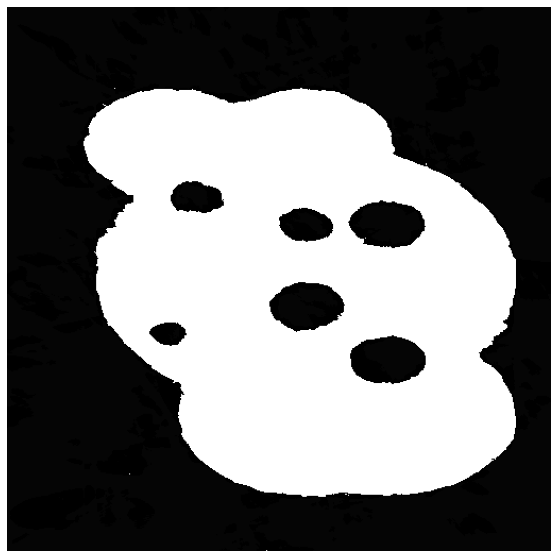

In [7]:
# # defining new gray levels
# gray_levels = [40, 60, 200]
# dart.gray_levels = gray_levels
# update DART thresholds
dart.thresholds = dart.update_gray_thresholds()
# Segmentation step
segmented_img = dart.segment(init_rec)
print(f"Initial gray levels: {dart.thresholds}")
print(f"Gray levels in segmented image: {np.unique(segmented_img)}")
print(f"Mean absolute pixel error: {np.abs(img - segmented_img).mean()}")
print("Segmented image:")
plt.figure(figsize=(10,10)); plt.imshow(segmented_img,cmap='gray'); plt.axis('off')

<br/>
<h4>Boundary pixels</h4>

(-0.5, 511.5, 511.5, -0.5)

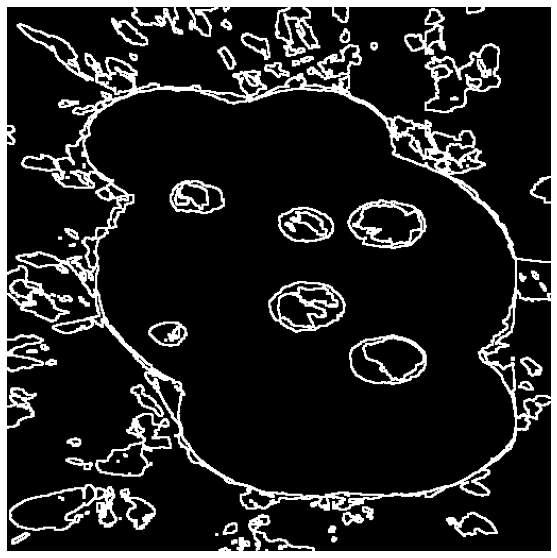

In [8]:
boundaries = dart.boundary_pixels(segmented_img)
plt.figure(figsize=(10,10)); plt.imshow(boundaries,cmap='gray'); plt.axis('off')

<br/>
<h4>Free pixels</h4>

(-0.5, 511.5, 511.5, -0.5)

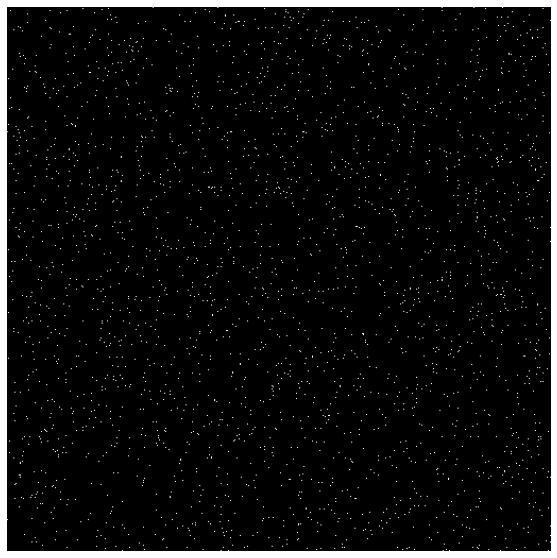

In [9]:
free_pixels = dart.free_pixels()
plt.figure(figsize=(10,10)); plt.imshow(free_pixels,cmap='gray'); plt.axis('off')

<br/>
<h4>Total free pixels</h4>

(-0.5, 511.5, 511.5, -0.5)

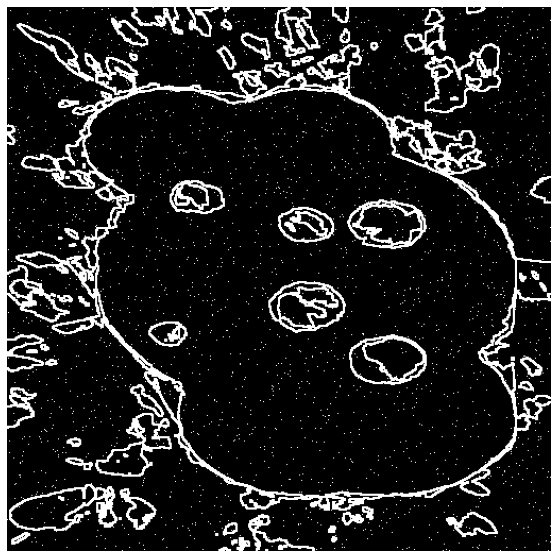

In [10]:
all_free_pixels = np.logical_or(boundaries,free_pixels)
plt.figure(figsize=(10,10)); plt.imshow(all_free_pixels,cmap='gray'); plt.axis('off')

<h4>Reconstruction of free pixels</h4>

Mean absolute pixel error: 2.697506256177946


(-0.5, 511.5, 511.5, -0.5)

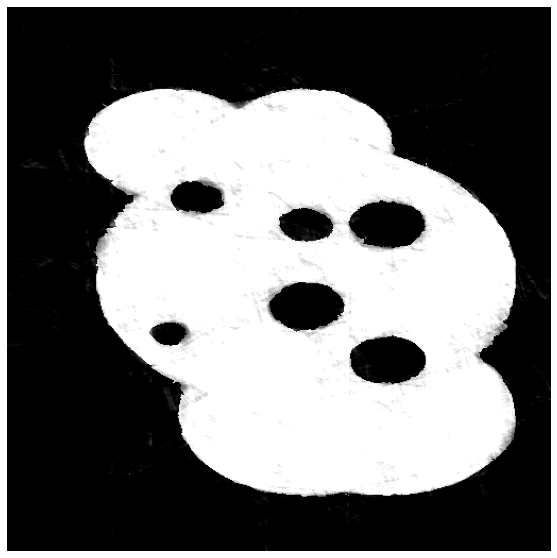

In [11]:
new_phantom_id = astra.data2d.create('-vol', vol_geom, data=img)
new_projector_id, new_sino_id, _ = project_from_2D(phantom_id=new_phantom_id,
                                                vol_geom=vol_geom,
                                                n_projections=n_projections,
                                                n_detectors=n_detectors,
                                                detector_spacing=det_spacing,
                                                angles=angles,
                                                noise_factor=noise_factor,
                                                use_gpu=True)

# fix gray levels and thresholds
_, first_rec = SART(vol_geom,segmented_img,new_projector_id,new_sino_id,
                    iters=1000, use_gpu=True)

print(f"Mean absolute pixel error: {np.abs(img - first_rec).mean()}")
plt.figure(figsize=(10,10)); plt.imshow(first_rec,cmap='gray'); plt.axis('off')

<br>
<h4>
Running full DART
</h4>

Mean absolute pixel error: 0.33401758453670416


(-0.5, 511.5, 511.5, -0.5)

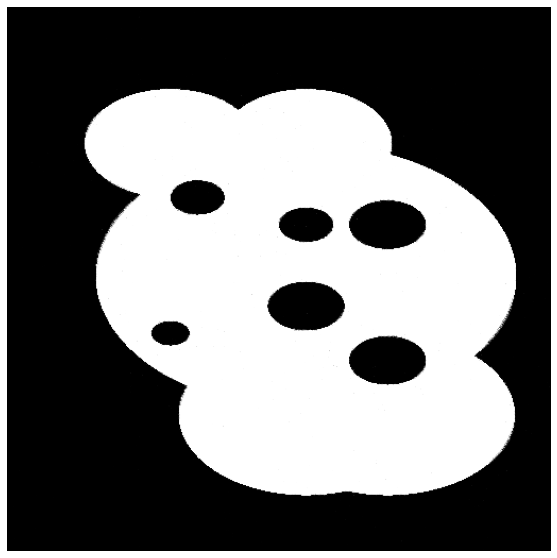

In [12]:
# fix gray levels and thresholds
dart.gray_levels = np.unique(img).astype(np.float16)
dart.thresholds = dart.update_gray_thresholds()
# run the algorithm
full_rec = dart.run(iters=dart_iters, rec_alg=rec_alg, rec_iter=rec_iters)
print(f"Mean absolute pixel error: {np.abs(img - full_rec).mean()}")
plt.figure(figsize=(10,10)); plt.imshow(full_rec,cmap='gray'); plt.axis('off')

Mean absolute pixel error: 0.004863739013671875


(-0.5, 511.5, 511.5, -0.5)

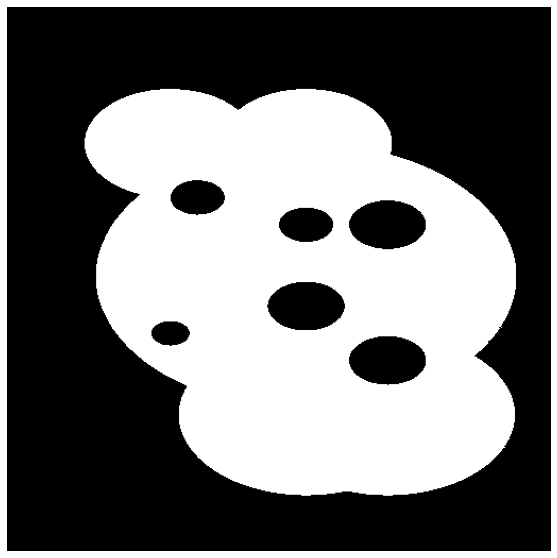

In [13]:
print(f"Mean absolute pixel error: {np.abs(img - dart.segment(full_rec)).mean()}")
# Image.fromarray(dart.segment(full_rec))
plt.figure(figsize=(10,10)); plt.imshow(dart.segment(full_rec),cmap='gray'); plt.axis('off')

<h4>SART comparison</h4>

Mean absolute pixel error: 1.4591071192117575


(-0.5, 511.5, 511.5, -0.5)

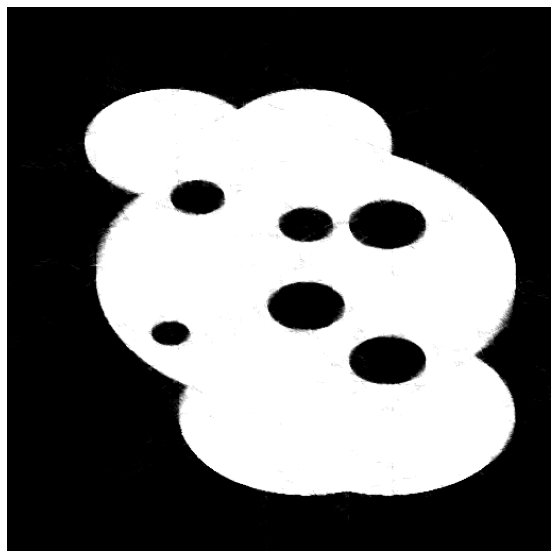

In [14]:
_, sart_res = SART(vol_geom,0,projector_id,sino_id,
                    iters=comp_iters, use_gpu=True)
print(f"Mean absolute pixel error: {np.abs(img - sart_res).mean()}")
plt.figure(figsize=(10,10)); plt.imshow(sart_res,cmap='gray'); plt.axis('off')

Mean absolute pixel error: 0.18482208251953125


(-0.5, 511.5, 511.5, -0.5)

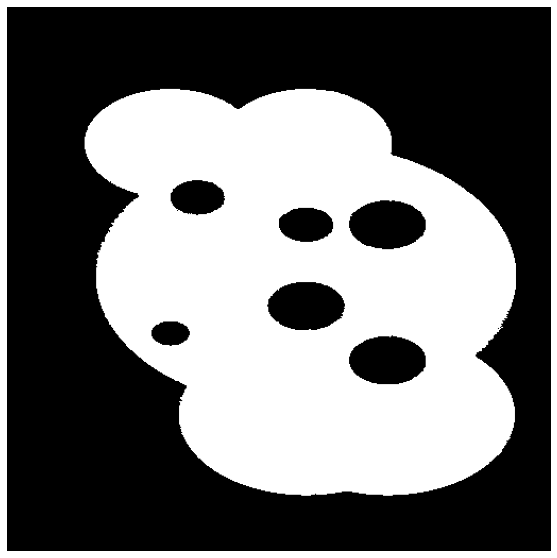

In [15]:
print(f"Mean absolute pixel error: {np.abs(img - dart.segment(sart_res)).mean()}")
plt.figure(figsize=(10,10)); plt.imshow(dart.segment(sart_res),cmap='gray'); plt.axis('off')

AxesSubplot(0.125,0.536818;0.227941x0.343182)
AxesSubplot(0.398529,0.536818;0.227941x0.343182)
AxesSubplot(0.672059,0.536818;0.227941x0.343182)
AxesSubplot(0.125,0.125;0.227941x0.343182)
AxesSubplot(0.398529,0.125;0.227941x0.343182)
AxesSubplot(0.672059,0.125;0.227941x0.343182)


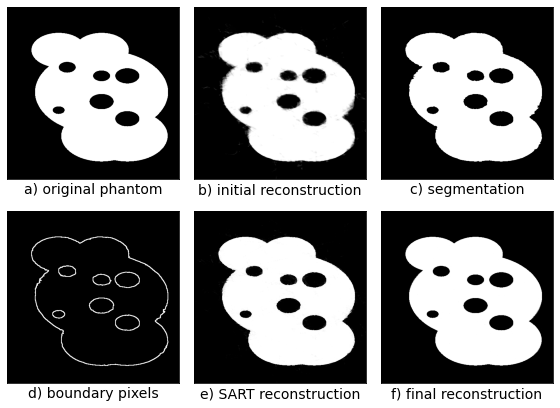

In [40]:
font = { 'size'   : 14}
plt.rc('font', **font)

fig, ax = plt.subplots(2,3, figsize=(8,6))

ax[0,0].imshow(img, cmap="Greys_r")
ax[0,0].set_xlabel("a) original phantom")
ax[0,1].imshow(init_rec, cmap="Greys_r")
ax[0,1].set_xlabel("b) initial reconstruction")
ax[0,2].imshow(segmented_img, cmap="Greys_r")
ax[0,2].set_xlabel("c) segmentation")
ax[1,0].imshow(boundaries, cmap="Greys_r")
ax[1,0].set_xlabel("d) boundary pixels")
ax[1,1].imshow(first_rec, cmap="Greys_r")
ax[1,1].set_xlabel("e) SART reconstruction")
ax[1,2].imshow(full_rec, cmap="Greys_r")
ax[1,2].set_xlabel("f) final reconstruction")

for x in ax:
    for y in x:
        print(y)
        y.tick_params(left = False, bottom = False)
        y.set_xticks([])
        y.set_yticks([])
plt.tight_layout()
plt.show()
